# Importa dependências

In [1]:
import pdfplumber as pdfpb
import json
import os
import re
import os.path as osp
import pathlib
import tarfile
import bz2
from zipfile import ZipFile
from pyunpack import Archive


##Classe com vários métodos de pre-processamento de texto em português criado pelo grupo F03
import utils.preprocessing_portuguese as preprossPT

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from matplotlib import pyplot as plt, rcParams, ticker
import matplotlib as mpl
import numpy as np
import pandas as pd 

from wordcloud import WordCloud




# Cálculo do TF-IDF

In [15]:
def limpeza_texto(page_text):
    txt_process = preprossPT.TextPreProcessing()
    
    page_text = page_text.lower()
    
    page_text = txt_process.remove_pronouns(page_text)

    page_text = txt_process.remove_reduced_or_contracted_words(page_text)

    page_text = txt_process.remove_adverbs(page_text)

    page_text = txt_process.remove_special_characters(page_text)

    page_text = txt_process.remove_excessive_spaces(page_text)

    page_text = txt_process.remove_accents(page_text)

    page_text = txt_process.remove_stopwords(page_text)

    page_text = txt_process.remove_symbols_from_numbers(page_text)

    page_text = txt_process.remove_numbers(page_text)

    page_text = txt_process.remove_urls(page_text)
    
    page_text = txt_process.remove_hour(page_text)
    
    page_text = txt_process.remove_person_names(page_text)
    
    #Removendo letras sozinhas no texto
    page_text = re.sub(r'(?:^| )\w(?:$| )', ' ', page_text).strip()

    page_text = page_text.replace("_","")
    
    return page_text

In [ ]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [ ]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [ ]:
base_path = "../data/documentos_municipios/docs-cidades-jul2021/"

#filename = f"{base_path}documentos_json/pirapetinga.json"

files = os.listdir(base_path+"documentos_json/")



cities = [city.split(".")[0] for city in files if city.split(".")[1]=='json']


##Ler até 10 páginas de cada arquivo
for page in range(10):

    pages_content = []

    #print(files)
    for filename in files:
        if os.path.splitext(filename)[1] == '.json':
            print("Municipio: ", filename)
            with open(base_path+"documentos_json/"+filename) as f:
                lines = f.readlines() # lê o conteúdo (pode ser lido em um stream, se achar necessário)
                #print("document id                     ", "  #", " status")
                for line in lines: # um doc por linha
                    document = json.loads(line) # alguns arquivos tem problemas, portanto, verifique o status.
                    #print(document["file_id"], f"{document['n_pages']:>03d}", document["status"])
                    if document["status"] != "FAILED" and document["text_content"]:
                        #print(document["file_id"])
                        #print(document["text_content"][0:1])
                        content = ""
                        #Pegar o conteúdo das páginas, incrementa a cada iteração
                        for k in range(page+1):
                            if len(document["text_content"]) > k:
                                content = content+" "+document["text_content"][k]
                        pages_content.append(content)


    print(len(pages_content))
    for i in range(len(pages_content)):
        for city in cities:
            pages_content[i] = pages_content[i].lower().replace(city, "")
            
        pages_content[i] = limpeza_texto(pages_content[i])

    #print(pages_content[0])

    #Cálculo do TF-IDF: https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.YOZcPhNKgqy
    #instantiate CountVectorizer() 
    cv=CountVectorizer() 

    # this steps generates word counts for the words in your docs 
    word_count_vector=cv.fit_transform(pages_content)
    
     
    print(word_count_vector.shape)
    
    
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
    tfidf_transformer.fit(word_count_vector)
    
    # print idf values 
    df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 

    # sort ascending: The lower the IDF value of a word, the less unique it is to any particular document
    print(df_idf.sort_values(by=['idf_weights']))
    
    # count matrix 
    count_vector=cv.transform(pages_content) 

    # tf-idf scores 
    tf_idf_vector=tfidf_transformer.transform(count_vector)
    
    feature_names = cv.get_feature_names() 
     
    #get tfidf vector for first document 
    first_document_vector=tf_idf_vector[0] 

    #print the scores 
    df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
    df.sort_values(by=["tfidf"],ascending=False)
    
    with open(base_path+"documentos_json/"+"result_pages"+str(page+1)+".txt", "w") as arq_saida:
        arq_saida.write(str(df.head(25)))
    
    
    
    '''df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)
    #print (df.head(25))
    
    #vec = tfIdfVectorizer.named_steps['vec']
    features = tfIdfVectorizer.get_feature_names()
    print(features)
    
    #df = top_tfidf_feats(df, features)
    df.columns = ['txt', 'TF-IDF']
    print(df)

    with open(base_path+"documentos_json/"+"result_pages"+str(page+1)+".txt", "w") as arq_saida:
        arq_saida.write(str(df.head(25)))
        
    plot_tfidf_classfeats_h(df)'''
    


# Nuvem de palavras TF e IDF

In [2]:
def gera_wordcloud(df, pg, metodo, nomeArq, freq):
    
    # import the desired colormap from matplotlib
    cmap = mpl.cm.YlGnBu(np.linspace(0,1,20)) 
    # the darker part of the matrix is selected for readability
    cmap = mpl.colors.ListedColormap(cmap[-10:,:-1])
    
    #tf baixo tende a implicar em idf alto
    df = df[[pg+'_page_term', pg+'_page_'+metodo]].sort_values(by=[pg+'_page_'+metodo], ascending=False)

    df = df[(df[pg+"_page_term"] != "minas") & (df[pg+"_page_term"]  != "mg") & (df[pg+"_page_term"]  != "gerais")]
    #print(freq)
    dictTerm = dict(zip(df[pg+"_page_term"], freq))
    
    #wordcloud = WordCloud(background_color="white", max_words=150, colormap=cmap).generate_from_frequencies(dictTerm)
    wordcloud = WordCloud(background_color="white", max_words=150, colormap=cmap).fit_words(dictTerm)
    
    # remove plot axes
    plt.axis("off")

    plt.imshow(wordcloud)

    # save the image
    plt.savefig(base_path+nomeArq)

    
    

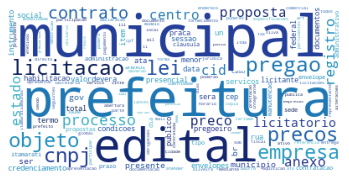

In [3]:
base_path = "../data/caracterizacao/"

dataTF = pd.read_csv(base_path+"tf_1_to_3_pages.csv") 

dataIDF = pd.read_csv(base_path+"idf_1_to_3_pages.csv") 



#Calcular TF
gera_wordcloud(dataTF, str(1), "tf", "wordcloudTF_1pg.png", dataTF['1_page_tf'])
gera_wordcloud(dataTF, str(2), "tf", "wordcloudTF_2pg.png", dataTF['2_page_tf'])
gera_wordcloud(dataTF, str(3), "tf", "wordcloudTF_3pg.png", dataTF['3_page_tf'])

dataTFMa10 = dataTF[dataTF["1_page_tf"] >= 10]
gera_wordcloud(dataTFMa10, str(1), "tf", "wordcloudTFMa10_1pg.png", dataTFMa10['1_page_tf'])



#Calcular IDF
freq = dataIDF['1_page_idf'].max() - dataIDF['1_page_idf']
gera_wordcloud(dataIDF, str(1), "idf", "wordcloudIDF_1pg.png", freq)


#Filtrar IDF < 8

dataIDFMe8 = dataIDF[dataIDF["1_page_idf"] < 8]
freq = dataIDFMe8['1_page_idf'].max() - dataIDFMe8['1_page_idf']
gera_wordcloud(dataIDFMe8, str(1), "idf", "wordcloudIDFMe8_1pg.png", freq)

gera_wordcloud(dataIDFMe8, str(2), "idf", "wordcloudIDFMe8_2pg.png", freq)

gera_wordcloud(dataIDFMe8, str(3), "idf", "wordcloudIDFMe8_3pg.png", freq)


#Filtrar IDF > 8
dataIDFMa8 = dataIDF[dataIDF["1_page_idf"] > 8]
#print(dataIDFMa8.head(5))
freq = dataIDFMa8['1_page_idf'].max() - dataIDFMa8['1_page_idf']
gera_wordcloud(dataIDFMa8, str(1), "idf", "wordcloudIDFMa8_1pg.png", freq)

gera_wordcloud(dataIDFMa8, str(2), "idf", "wordcloudIDFMa8_2pg.png", freq)

gera_wordcloud(dataIDFMa8, str(3), "idf", "wordcloudIDFMa8_3pg.png", freq)

#dataTFIDF = dataTF[dataTF["1_page_term"] in dataIDFMa8["1_page_term"]]

dataTFIDF = dataTF[dataTF['1_page_term'].isin(dataIDFMe8["1_page_term"])]
gera_wordcloud(dataTFIDF, str(1), "tf", "dataTFIDF_1pg.png", dataTFIDF['1_page_tf'])


dataIDFMe8 = dataIDF[dataIDF["2_page_idf"] < 8]
dataTFIDF = dataTF[dataTF['2_page_term'].isin(dataIDFMe8["2_page_term"])]
gera_wordcloud(dataTFIDF, str(2), "tf", "dataTFIDF_2pg.png", dataTFIDF['2_page_tf'])

dataIDFMe8 = dataIDF[dataIDF["3_page_idf"] < 8]
dataTFIDF = dataTF[dataTF['3_page_term'].isin(dataIDFMe8["3_page_term"])]
gera_wordcloud(dataTFIDF, str(3), "tf", "dataTFIDF_3pg.png", dataTFIDF['3_page_tf'])

